In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load the data
from uwv.config import CBS80072NED, CBS_OPENDATA_PROCESSED_DATA_DIR, OUTPUT_DIR

cbs = pd.read_parquet(CBS_OPENDATA_PROCESSED_DATA_DIR / f"{CBS80072NED}.parquet")

2024-08-23 13:44:59.414 | INFO     | uwv.config:<module>:11 - PROJ_ROOT path is: C:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv


In [3]:
# Filter out rows where 'period_quarter_number' is 0
cbs = cbs[cbs['period_quarter_number'] != 0]

# Map quarters to months and create the 'date' column
cbs['month'] = cbs['period_quarter_number'].map({1: 1, 2: 4, 3: 7, 4: 10})
cbs['date'] = pd.to_datetime({'year': cbs['period_year'], 'month': cbs['month'], 'day': 1})

# Set this new 'date' column as the index
cbs.set_index('date', inplace=True)

In [4]:
# Filter data based on 'sbi_title'
sbi_code = 'T001081'  # Example: A-U Alle economische activiteiten
filtered_cbs = cbs[cbs['sbi'] == sbi_code]

# Filter the data to include only dates from 2016 to 2023
filtered_cbs = filtered_cbs.loc['2016-01-01':'2023-12-31']

In [5]:
filtered_cbs.index.freq = 'QS'  # Set the frequency to quarterly

In [6]:
# Drop any NaN values to clean the dataset
filtered_cbs = filtered_cbs.dropna()

In [7]:
# Check the columns and ensure the sick_leave_percentage column is in the correct format
filtered_cbs['sick_leave_percentage'] = filtered_cbs['sick_leave_percentage'].astype(float)

<Axes: title={'center': 'Sick Leave Percentage'}, xlabel='date'>

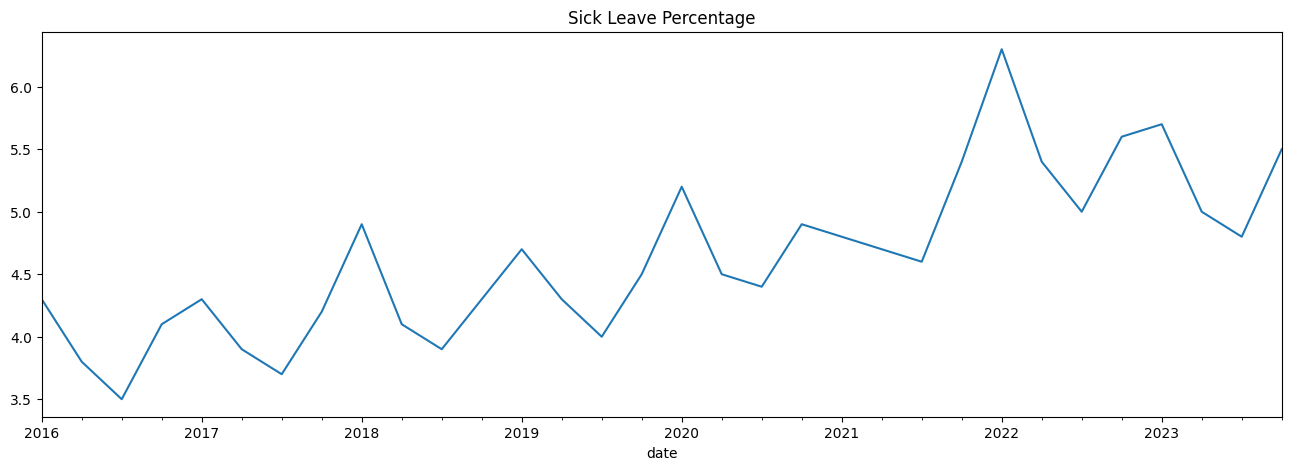

In [8]:
# Plot the sick_leave_percentage
filtered_cbs['sick_leave_percentage'].plot(figsize=(16,5), title='Sick Leave Percentage')

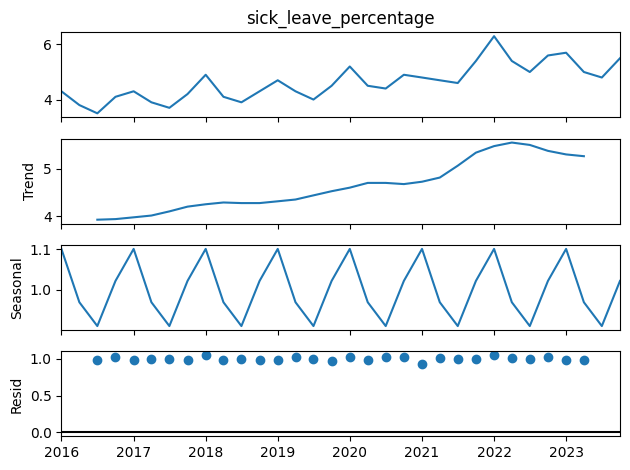

In [9]:
# Seasonal decomposition to understand the components of the time series
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(filtered_cbs['sick_leave_percentage'], model='multiplicative')
result.plot()
plt.show()

<Axes: title={'center': 'Seasonal Component of Sick Leave Percentage'}, xlabel='date'>

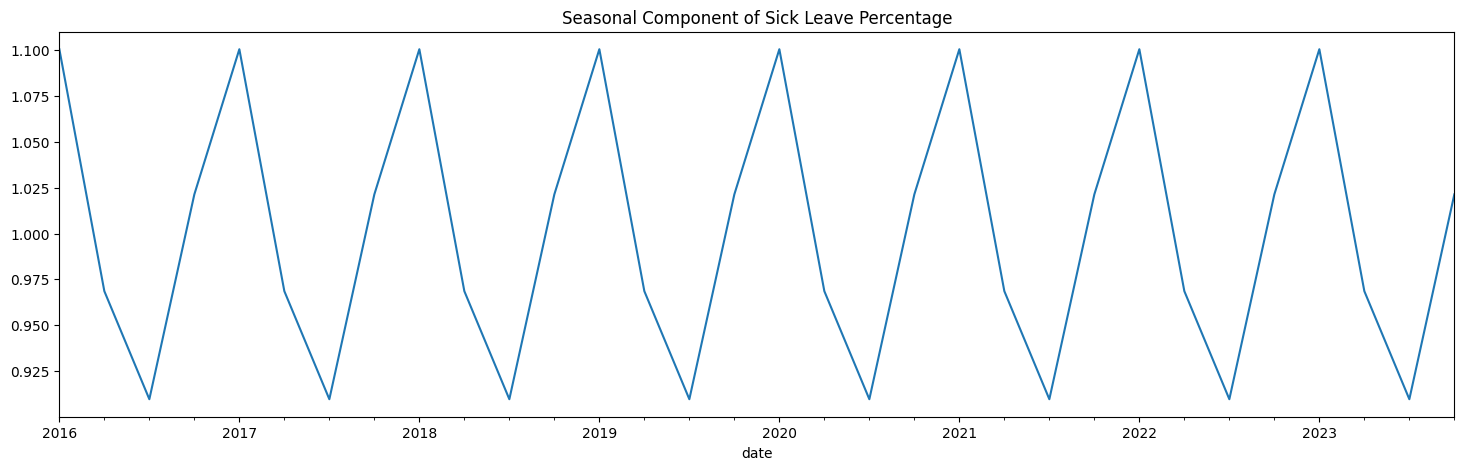

In [10]:
result.seasonal.plot(figsize=(18,5), title='Seasonal Component of Sick Leave Percentage')

In [11]:
# Define the training and test datasets
train = filtered_cbs.iloc[:-8]  # Use all but the last 8 quarters for training
test = filtered_cbs.iloc[-8:]   # Use the last 8 quarters for testing

In [12]:
# Auto ARIMA model to suggest the best SARIMAX configuration
from pmdarima import auto_arima
auto_arima(train['sick_leave_percentage'], seasonal=True, m=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                   24
Model:             SARIMAX(1, 1, [1], 4)   Log Likelihood                   7.523
Date:                   Fri, 23 Aug 2024   AIC                             -7.045
Time:                           13:45:09   BIC                             -3.062
Sample:                       01-01-2016   HQIC                            -6.268
                            - 10-01-2021                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4203      0.062      6.830      0.000       0.300       0.541
ar.S.L4       -0.9987      0.244     -4.097      0.000      -1.477      -0.521
ma.S.L4        0.9308      6.401      0.145      0.884     -11.615      13.477
sigma2         0.0182      0.107      0.170      0.865      -0.192       0.228
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.59
Prob(Q):                              0.80   Prob(JB):                         0.74
Heteroskedasticity (H):               3.50   Skew:                             0.37
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
# Fit the SARIMAX model without differencing
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [15]:
model = SARIMAX(train['sick_leave_percentage'],
                order=(1, 0, 1),  # No differencing
                seasonal_order=(1, 0, 1, 4),  # Seasonal order with no differencing
                enforce_stationarity=False,
                enforce_invertibility=False)

In [16]:
results = model.fit(maxiter=1000, method='lbfgs')

In [17]:
# Summary of the SARIMAX model
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:             sick_leave_percentage   No. Observations:                   24
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 4)   Log Likelihood                   2.428
Date:                           Fri, 23 Aug 2024   AIC                              5.144
Time:                                   13:47:16   BIC                              9.595
Sample:                               01-01-2016   HQIC                             5.757
                                    - 10-01-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0220      0.030     34.449      0.000       0.964       1.080
ma.L1         -1.0000   3707.929     -0.000

In [18]:
# Predictions
start = len(train)
end = len(train) + len(test) - 1
predictions = results.predict(start, end).rename('SARIMAX Predictions')

<Axes: title={'center': 'Sick Leave Percentage - Test vs Predictions'}, xlabel='date'>

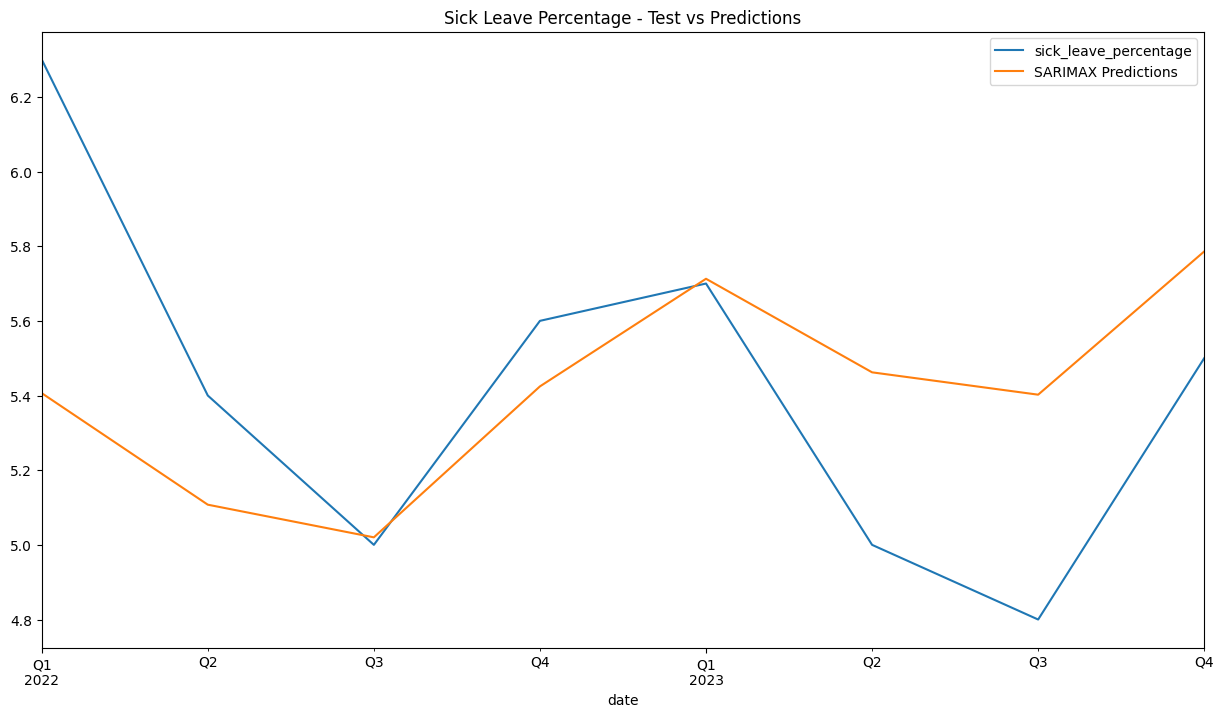

In [19]:
# Plotting the results
ax = test['sick_leave_percentage'].plot(legend=True, figsize=(15,8), title='Sick Leave Percentage - Test vs Predictions')
predictions.plot(legend=True)

In [20]:
# Calculate RMSE for predictions
from statsmodels.tools.eval_measures import rmse
rmse_value = rmse(test['sick_leave_percentage'], predictions)
print(f'RMSE: {rmse_value}')

RMSE: 0.44348347961296064


In [21]:
# Train SARIMAX on the full dataset
final_model = SARIMAX(filtered_cbs['sick_leave_percentage'],
                      order=(1, 0, 1),  # No differencing
                      seasonal_order=(1, 0, 1, 4),  # Seasonal order with no differencing
                      enforce_stationarity=False,
                      enforce_invertibility=False)

In [22]:
final_results = final_model.fit(maxiter=1000, method='lbfgs')

c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
# Forecast future values
forecast_steps = 8  # Number of quarters to forecast
fcast = final_results.predict(len(filtered_cbs), len(filtered_cbs) + forecast_steps - 1).rename('SARIMAX Forecast')

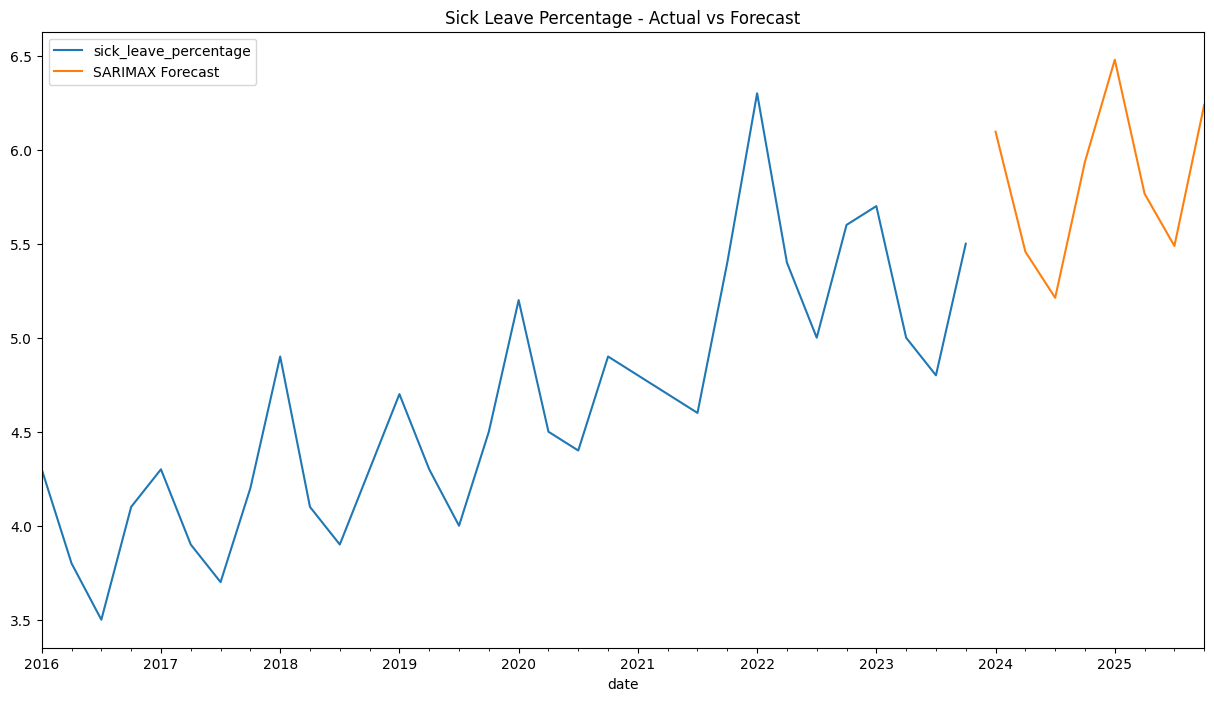

In [25]:
# Plotting the forecast
ax = filtered_cbs['sick_leave_percentage'].plot(legend=True, figsize=(15,8), title='Sick Leave Percentage - Actual vs Forecast')
fcast.plot(legend=True)

plt.show()